In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
from collections import defaultdict
from copy import deepcopy
import gdown
import json

In [ ]:
# Torch
import urllib
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## EEG data

Loading the data from the reference [article](https://www.mdpi.com/2227-7390/10/15/2819):

In [ ]:
if not os.path.exists('dataset'):
    !wget --content-disposition 'https://figshare.com/ndownloader/files/35265655' -O 'EEG_dataset.zip'
    !unzip -q 'EEG_dataset.zip'
    ignore_files = ['dataset/Participant 3/Participant 1', 'dataset/Participant 3/Participant 2']
    for path in ignore_files:
        if os.path.exists(path):
            !rm -rf '{path}'

Read the data:

In [ ]:
channels = pd.read_csv('dataset/Channels.dat', header=None, engine='python')
channels = channels[0].apply(lambda x: x.split(' ')[1])
columns = channels.tolist() + ['extra_1', 'extra_2', 'extra_3']
left_channels = []
right_channels = []

In [ ]:
from scipy.signal import butter, filtfilt, sosfiltfilt

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    #nyquist = 0.5 * fs  # Nyquist frequency
    #low = lowcut / nyquist
    #high = highcut / nyquist
    sos = butter(N=order, Wn=[lowcut, highcut], btype='bandpass', fs=fs, output='sos')  # Design the filter
    return sosfiltfilt(sos, data)  # Apply the filter

def filter_eeg_into_bands(df, fs):
    # Define frequency bands
    bands = {
        'delta': (1, 4),
        'theta': (5, 8),
        'alpha': (8, 12),
        'beta': (13, 30),
        'gamma': (31, 45)
    }

    # Initialize dictionary to store filtered data
    filtered_dfs = {}

    #Referencing
    average_signal = df.mean(axis=1)
    df_referenced = df.sub(average_signal, axis=0)

    #Centering
    df_centered = df_referenced - df_referenced.mean(axis=0)

    # Apply bandpass filtering for each frequency band
    for band, (lowcut, highcut) in bands.items():
        filtered_data = butter_bandpass_filter(df_centered.values, lowcut, highcut, fs)
        filtered_df = pd.DataFrame(filtered_data, columns=df_centered.columns)
        filtered_dfs[band] = filtered_df
    #filtered_dfs['raw'] = df
    #filtered_dfs['full_centered'] = df_centered
    return filtered_dfs

In [ ]:
datasets = defaultdict(lambda: defaultdict(dict))
for root, dirs, files in os.walk('dataset'):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        try:
            if file_name[-4:]=='.dat' and file_name!='Channels.dat':
                folders = file_path.split('/')
                print(file_path)
                ds = folders[2].replace('Cubes for spectra', 'cube').replace('Figs for spectra', 'monalisa').replace('Background', 'bg')
                participant = folders[1].split(' ')[-1]
                f_ops = folders[-1].split('.dat')[0].split('_')
                if len(f_ops)>2:
                    intensity = f'{f_ops[1]}_{f_ops[2]}'
                    I_value = float(f_ops[2])
                else:
                    intensity = None
                #print(f'{ds}, {participant}, {intensity}')
                raw_EEG_df = pd.read_csv(file_path, delimiter='   ', names=columns, header=None, engine='python')
                #Keep only the 31 channels, ignore the last 3 (used for reference calibration)
                raw_EEG_df = raw_EEG_df.drop(['extra_1', 'extra_2', 'extra_3'], axis=1)
                #Filter bands
                filtered_df_dict = filter_eeg_into_bands(raw_EEG_df, fs=250)
                #filtered_df_dict = {'raw': raw_EEG_df}
                if intensity:
                    for band in filtered_df_dict:

                        filtered_df_dict[band]['brightness'] = I_value
                        #Classes from 0 to 9
                        filtered_df_dict[band]['brightness_level'] = int(I_value*10) - 1

                datasets[ds][participant][intensity] = filtered_df_dict

        except Exception as e:
                print(f'Could not read {file_path}: {e}')

dataset/Participant 2/Figs for spectra/Backgr_int_0.6.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.3.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.1.dat
dataset/Participant 2/Figs for spectra/Backgr_int_1.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.9.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.8.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.4.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.2.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.5.dat
dataset/Participant 2/Figs for spectra/Backgr_int_0.7.dat
dataset/Participant 2/Cubes for spectra/Backgr_int_0.2_type_0.4.dat
dataset/Participant 2/Cubes for spectra/Backgr_int_0.4_type_0.4.dat
dataset/Participant 2/Cubes for spectra/Backgr_int_0.7_type_0.4.dat
dataset/Participant 2/Cubes for spectra/Backgr_int_0.8_type_0.4.dat
dataset/Participant 2/Cubes for spectra/Backgr_int_0.1_type_0.4.dat
dataset/Participant 2/Cubes for spectra/Backgr_int_0.6_type_0.4.dat
dataset/Partic

In [ ]:
#datasets['cube']['2']['int_0.6']['alpha'].head()

In [ ]:
#datasets['cube']['2']['int_0.6']['alpha'].iloc[0]

Now, the 2 separate datasets prepared as torch tensors:

In [ ]:
def prepare_datasets(datasets=datasets):
    contrasts = [0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1]
    bands = {
        'delta': (1, 4),
        'theta': (5, 8),
        'alpha': (8, 12),
        'beta': (13, 30),
        'gamma': (31, 45),
        #'raw': None,
        #'full_centered': None
    }
    X_data = {'cube':{}, 'monalisa':{}}
    y_data = {'cube':{}, 'monalisa':{}}
    trial_sizes =  {'cube':[], 'monalisa':[]}

    for ds_name in ['cube', 'monalisa']:
        for participant in range(1,6):
            for I in contrasts:
                for band in bands:
                    df_ =  datasets[ds_name][str(participant)][f'int_{str(I)}'][band]
                    data_ts = torch.tensor(df_.values).to(device)
                    if band not in X_data[ds_name]:
                        X_data[ds_name][band] = data_ts[:, :-2]
                        y_data[ds_name][band] = data_ts[:, -1].to(torch.int64)
                    else:
                        X_data[ds_name][band] = torch.vstack((X_data[ds_name][band], data_ts[:, :-2]))
                        y_data[ds_name][band] = torch.cat((y_data[ds_name][band], data_ts[: ,-1].to(torch.int64)))
                #Add sizes of each experimental data stacked, all bands should have the same n_points for a given experiment
                trial_sizes[ds_name].append(data_ts.shape[0])

    return X_data, y_data, trial_sizes

In [ ]:
X_data, y_data, trial_sizes = prepare_datasets()

One participant data:

In [ ]:
def SingleSubjectData(ds_name, participant):
    contrasts = [0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1]
    bands = {
        'delta': (1, 4),
        'theta': (5, 8),
        'alpha': (8, 12),
        'beta': (13, 30),
        'gamma': (31, 45),
        #'raw': None,
        #'full_centered': None
    }

    X_data_k = {}
    y_data_k = {}
    for I in contrasts:
        for band in bands:
            df_ =  datasets[ds_name][str(participant)][f'int_{str(I)}'][band]
            data_ts = torch.tensor(df_.values).to(device)
            if band not in X_data_k:
                X_data_k[band] = data_ts[:, :-2]
                y_data_k[band] = data_ts[:, -1].to(torch.int64)
            else:
                X_data_k[band] = torch.vstack((X_data_k[band], data_ts[:, :-2]))
                y_data_k[band] = torch.cat((y_data_k[band], data_ts[: ,-1].to(torch.int64)))
    return X_data_k, y_data_k

In [ ]:
#X_data_k, y_data_k = SingleSubjectData(ds_name = 'monalisa', participant = 5)
#X = X_data_k['gamma'].to(torch.float32)
#y = y_data_k['gamma'].to(torch.float32)

Shuffling on batch level to keep the temporal order of each data intact:

In [ ]:
def shuffle_batches(X, y, sequence_size, trials):
    """
    Divides X and y (numpy arrays) into batches of length batch_size,
    Shuffles the order of the batches while preserving temporal order of EEG temporal points,
    Reassembles the arrays.
    """
    batches_X = []
    batches_y = []
    trial_boundaries = [0]
    S_remainder = 0
    #cumulative sizes of successive trials
    for size in trials:
        trial_boundaries.append(trial_boundaries[-1] + size)

    # Process each trial
    for i in range(len(trial_boundaries) - 1):
        start = trial_boundaries[i]
        end = trial_boundaries[i+1]
        trial_X = X[start:end]
        trial_y = y[start:end]

        n = trial_X.shape[0]
        num_full_batches = n // sequence_size
        remainder = n % sequence_size
        S_remainder += remainder
        # Create full batches from this trial
        for j in range(num_full_batches):
            batch_X = trial_X[j * sequence_size : (j+1) * sequence_size]
            batch_y = trial_y[j * sequence_size : (j+1) * sequence_size]
            batches_X.append(batch_X)
            batches_y.append(batch_y)

        #Add the leftover data from the trial as its own batch (if any)
        #if remainder > 0:
        #    batches_X.append(trial_X[-remainder:])
        #    batches_y.append(trial_y[-remainder:])
        # The remainder is ignored to not mess up the temporal order after shuffling

    # Shuffle the list of batches
    indices = np.arange(len(batches_X))
    np.random.shuffle(indices)
    X_shuffled = np.concatenate([batches_X[i] for i in indices], axis=0)
    y_shuffled = np.concatenate([batches_y[i] for i in indices], axis=0)

    return X_shuffled, y_shuffled, S_remainder

## DL Models

Importing `SHAP` library:

In [ ]:
!pip install shap
import shap

In [ ]:
# Load what is needed
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm
import time
import seaborn as sns

Define save/load functions to avoid repeated training:

In [ ]:
def save_model(model, model_path):
    torch.save(model.state_dict(), model_path)

In [ ]:
def load_model(model, model_path):
    model_dict = torch.load(model_path, weights_only=True, map_location=torch.device(device))
    model.load_state_dict(model_dict)

Log all session results to collect it easier later:

In [ ]:
ann_results_dict = {'cube':{}, 'monalisa':{}}
rnn_results_dict = {'cube':{}, 'monalisa':{}}

In [ ]:
# Run preliminary cells from here

In [ ]:
#!zip -r results_h_rnn_cube_delta.zip results

### RNN

Previous ANN accuracy results:

In [ ]:
prev_acc = {
    'delta':  {'monalisa': 0.321, 'cube': 0.325},
    'theta':  {'monalisa': 0.493, 'cube': 0.444},
    'alpha':  {'monalisa': 0.521, 'cube': 0.487},
    'beta':   {'monalisa': 0.645, 'cube': 0.632},
    'gamma':  {'monalisa': 0.632, 'cube': 0.631}
}

The data would need a different structuring to match the RNN shape: `  (batch_size, sequence_length, n_features)`

In [ ]:
torch.cuda.empty_cache()

In [ ]:
dataset = 'monalisa'
band = 'gamma'
X = X_data[dataset][band].to(torch.float32)
y = y_data[dataset][band].to(torch.float32)
assert len(trial_sizes[dataset]) == 50
assert sum(trial_sizes[dataset]) == X.shape[0]

In [ ]:
# Input options
n_channels = 31
sequence_length = 100
batch_size = 32
# Output options
n_classes = 10

# Special Random Shuffle that preserves local temporal order
X_shuffled, y_shuffled, S_remainder = shuffle_batches(X.cpu().numpy(), y.cpu().numpy(), sequence_length, trials = trial_sizes[dataset])
# Reshape for the RNN
X_shuffled = X_shuffled.reshape(-1, sequence_length, n_channels)
y_shuffled = y_shuffled.reshape(-1, sequence_length)
# 1 prediction for every sequence to simplify, since the sequences belong to one brightness class
y_shuffled = y_shuffled[:, -1]

# Split: No need to worry about order in the first dimension anymore, since its saved in the second
X_train, X_temp, y_train, y_temp = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Make tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64).to(device)
y_val_tensor   = torch.tensor(y_val, dtype=torch.int64).to(device)
y_test_tensor  = torch.tensor(y_test, dtype=torch.int64).to(device)

# Make dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# Make data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#Simple tests to check if the Shuffling is done right
assert X_shuffled.shape[0]*sequence_length + S_remainder == X.shape[0]
assert y_shuffled.shape[0]*sequence_length + S_remainder == y.shape[0]
#Check the splitting
assert X_shuffled.shape[0] == X_train_tensor.shape[0] + X_val_tensor.shape[0] + X_test_tensor.shape[0]
assert y_shuffled.shape[0] == y_train_tensor.shape[0] + y_val_tensor.shape[0] + y_test_tensor.shape[0]

In [ ]:
X_train.shape, y_train.shape

((6000, 100, 31), (6000,))

Define the model architecture:

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=1, dropout=0.3):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dim_per_head = embed_dim // num_heads

        # Linear projections for query, key, and value.
        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)

        # Final linear projection after combining heads.
        self.out_linear = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x: input tensor of shape (batch_size, seq_length, embed_dim)
        Returns:
            A tensor of shape (batch_size, seq_length, embed_dim) after applying multi-head self-attention.
        """
        B, T, _ = x.shape

        # Linear projections
        Q = self.q_linear(x)  # (B, T, embed_dim)
        K = self.k_linear(x)  # (B, T, embed_dim)
        V = self.v_linear(x)  # (B, T, embed_dim)

        # Reshape for multiple heads: (B, T, num_heads, dim_per_head)
        # and then transpose to shape (B, num_heads, T, dim_per_head)
        Q = Q.view(B, T, self.num_heads, self.dim_per_head).transpose(1, 2)
        K = K.view(B, T, self.num_heads, self.dim_per_head).transpose(1, 2)
        V = V.view(B, T, self.num_heads, self.dim_per_head).transpose(1, 2)

        # Scaled dot-product attention.
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.dim_per_head**0.5
        attn_weights = F.softmax(scores, dim=-1)  # (B, num_heads, T, T)
        attn_output = torch.matmul(attn_weights, V)  # (B, num_heads, T, dim_per_head)

        # Combine heads: transpose and reshape to (B, T, embed_dim)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, self.embed_dim)

        # Final linear projection and dropout.
        attn_output = self.out_linear(attn_output)
        attn_output = self.dropout(attn_output)

        return attn_output

In [ ]:
class EEG_RNN(nn.Module):
    def __init__(self, input_shape, n_classes, rnn_layers = (128, 256, 128), bidirectional=True):
        super(EEG_RNN, self).__init__()
        batch_size, sequence_length, num_channels = input_shape
        h_conv1 = 128
        h_size_1, h_size_2, h_size_3 = rnn_layers
        dirs = (2 if bidirectional else 1)

        # CNN front layer
        self.conv1    = nn.Conv1d(in_channels=num_channels, out_channels=h_conv1, kernel_size=3, padding=1)
        self.bn_conv  = nn.BatchNorm1d(h_conv1)
        self.dropout0 = nn.Dropout(0.2)

        # Hidden layers
        #RNN 1
        self.h1 = nn.LSTM(input_size=h_conv1,
                          hidden_size=h_size_1,
                          num_layers=1,
                          batch_first=True,
                          bidirectional=bidirectional) # First layer
        self.ln1 = nn.LayerNorm(h_size_1*dirs)
        self.dropout1 = nn.Dropout(0.3)
        # RNN 2
        self.h2 = nn.LSTM(input_size=h_size_1*dirs,
                          hidden_size=h_size_2,
                          num_layers=1,
                          batch_first=True,
                          bidirectional=bidirectional) # 2nd  layer
        self.ln2 = nn.LayerNorm(h_size_2*dirs)
        self.dropout2 = nn.Dropout(0.3)
        # RNN 3
        self.h3 = nn.LSTM(input_size=h_size_2*dirs,
                          hidden_size=h_size_3,
                          num_layers=1,
                          batch_first=True,
                          bidirectional=bidirectional) # 3rd layer
        self.ln3 = nn.LayerNorm(h_size_3*dirs)
        self.dropout3 = nn.Dropout(0.3)

        # Attention
        self.attn = nn.Linear(h_size_3*dirs, 1)
        self.attn_multi = MultiHeadAttention(embed_dim=h_size_3*dirs, num_heads=16, dropout=0.2)

        # Output fc layer(s)
        self.fc_out = nn.Linear(h_size_3*dirs, n_classes)

        # Activation functions
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        # x: (batch_size, sequence_length, n_channels)
        # Initial CNN layer
        x = x.permute(0, 2, 1)               # -> (batch, n_channels, seq_len)
        x = self.conv1(x)                   # -> (batch, h_conv1, seq_len)
        x = self.bn_conv(x)
        x = self.tanh(x)
        x = self.dropout0(x)
        x = x.permute(0, 2, 1)

        # Pass through hidden layers with tanh activation
        output, _ = self.h1(x) # output: (batch_size, sequence_length, hidden_size_1*dirs)
        x = self.ln1(output)
        x = self.tanh(x)
        x = self.dropout1(x)

        output, _ = self.h2(x) # output: (batch_size, sequence_length, hidden_size_2*dirs)
        x = self.ln2(output)
        x = self.tanh(x)
        x = self.dropout2(x)

        output, _ = self.h3(x) # output: (batch_size, sequence_length, hidden_size_3*dirs)
        x = self.ln3(output)
        x = self.tanh(x)
        x = self.dropout3(x)


        attn_output = self.attn_multi(x)  #(B, T, embed_dim=hidden_size_3*dirs)
        # Pooling over time, for example with mean pooling.
        v = attn_output.mean(dim=1)

        # Final fc layer(s)
        #x = torch.flatten(v, start_dim=1)  # Shape: (batch_size*hidden_size)
        #v = self.tanh(self.fc1(v))
        x = self.fc_out(v)
        return x

In [ ]:
RNN_model = EEG_RNN((batch_size, sequence_length, n_channels), n_classes).to(device)
#RNN_model = EEG_CRNN(n_channels, n_classes).to(device)
loss_fct = nn.CrossEntropyLoss()
scaler = GradScaler()
optimizer = torch.optim.RMSprop(RNN_model.parameters(), lr=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[35, 40], gamma=0.5)
epochs = 50
loss_threshold = 1e-2

Note: change autocast back to float16, didnt work with LSTM

In [ ]:
def model_train():
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    duration = time.time()

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        #Training
        RNN_model.train()
        epoch_train_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        progress_bar = tqdm(train_loader, desc="Training", disable=False)
        for X_batch, y_batch in progress_bar:
            optimizer.zero_grad()

            # Forward pass with mixed precision
            #Use autocast with the new model
            #with autocast(device_type=torch.device(device).type, dtype=torch.float16, enabled=False):
            if True:
                output = RNN_model(X_batch)
                #print(torch.argmax(output, dim=1))
                loss = loss_fct(output, y_batch)
                epoch_train_loss += loss.item()

                #Calculate accuracy
                _, predicted = torch.max(output, 1)
                correct_predictions += (predicted == y_batch).sum().item()
                total_predictions += y_batch.size(0)


            # Backward pass and optimization with scaler
            #scaler.scale(loss).backward()
            #nn.utils.clip_grad_norm_(RNN_model.parameters(), max_norm=1.0)
            #scaler.step(optimizer)
            #scaler.update()

            # Regular backward pass
            loss.backward()
            nn.utils.clip_grad_norm_(RNN_model.parameters(), max_norm=1.0)
            optimizer.step()

            #Free up some memory
            #del output
            #torch.cuda.empty_cache()

            #Update progress bar
            progress_bar.set_postfix(loss=loss.item())
        # Training stats
        train_loss = epoch_train_loss/len(train_loader)
        accuracy = 100*correct_predictions/total_predictions
        train_losses.append(train_loss)
        train_accuracies.append(accuracy)
        print(f'Average epoch training loss: {train_loss:.3f}')
        print(f'Training accuracy: {accuracy:.3f}%')


        #Validation
        RNN_model.eval()
        epoch_val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        progress_bar = tqdm(val_loader, desc="Validation")
        for X_batch, y_batch in progress_bar:
            #with autocast(device_type=torch.device(device).type, dtype=torch.float16, enabled=False):
            if True:
                output = RNN_model(X_batch)
                loss = loss_fct(output, y_batch)
                epoch_val_loss += loss.item()

                #Calculate accuracy
                _, predicted = torch.max(output, 1)
                correct_predictions += (predicted == y_batch).sum().item()
                total_predictions += y_batch.size(0)

            # Update progress bar
            progress_bar.set_postfix(val_loss=loss.item())
        # Validation stats
        val_loss = epoch_val_loss/len(val_loader)
        accuracy = 100*correct_predictions/total_predictions
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)
        print(f'Average epoch validation loss: {val_loss:.3f}')
        print(f'Validation accuracy: {accuracy:.3f}% \n')

        #Scheduler
        scheduler.step()

        #Loss condition
        if val_loss <= loss_threshold or accuracy > 99.9:
            break


    duration = time.time() - duration
    print(f'RNN training and validation time (s): {duration:.1f}')

    return train_losses, train_accuracies, val_losses, val_accuracies, duration

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies, duration = model_train()

Epoch 1/50


Training: 100%|██████████| 188/188 [00:05<00:00, 32.14it/s, loss=2.12]


Average epoch training loss: 2.243
Training accuracy: 16.750%


Validation: 100%|██████████| 24/24 [00:00<00:00, 105.00it/s, val_loss=2.15]


Average epoch validation loss: 2.157
Validation accuracy: 20.533% 

Epoch 2/50


Training: 100%|██████████| 188/188 [00:04<00:00, 42.41it/s, loss=2.32]


Average epoch training loss: 2.136
Training accuracy: 23.050%


Validation: 100%|██████████| 24/24 [00:00<00:00, 110.61it/s, val_loss=1.99]


Average epoch validation loss: 2.048
Validation accuracy: 27.467% 

Epoch 3/50


Training: 100%|██████████| 188/188 [00:04<00:00, 42.55it/s, loss=2.08]


Average epoch training loss: 2.058
Training accuracy: 26.383%


Validation: 100%|██████████| 24/24 [00:00<00:00, 110.15it/s, val_loss=1.8]


Average epoch validation loss: 1.949
Validation accuracy: 32.533% 

Epoch 4/50


Training: 100%|██████████| 188/188 [00:04<00:00, 42.39it/s, loss=2.07]


Average epoch training loss: 1.980
Training accuracy: 29.900%


Validation: 100%|██████████| 24/24 [00:00<00:00, 105.84it/s, val_loss=1.89]


Average epoch validation loss: 1.888
Validation accuracy: 32.400% 

Epoch 5/50


Training: 100%|██████████| 188/188 [00:04<00:00, 41.92it/s, loss=1.8]


Average epoch training loss: 1.916
Training accuracy: 32.150%


Validation: 100%|██████████| 24/24 [00:00<00:00, 109.73it/s, val_loss=1.75]


Average epoch validation loss: 1.787
Validation accuracy: 37.467% 

Epoch 6/50


Training: 100%|██████████| 188/188 [00:04<00:00, 42.02it/s, loss=2.11]


Average epoch training loss: 1.829
Training accuracy: 35.650%


Validation: 100%|██████████| 24/24 [00:00<00:00, 111.13it/s, val_loss=1.7]


Average epoch validation loss: 1.708
Validation accuracy: 42.267% 

Epoch 7/50


Training: 100%|██████████| 188/188 [00:04<00:00, 41.53it/s, loss=1.98]


Average epoch training loss: 1.768
Training accuracy: 38.650%


Validation: 100%|██████████| 24/24 [00:00<00:00, 109.03it/s, val_loss=1.76]


Average epoch validation loss: 1.680
Validation accuracy: 42.133% 

Epoch 8/50


Training: 100%|██████████| 188/188 [00:04<00:00, 41.59it/s, loss=1.77]


Average epoch training loss: 1.716
Training accuracy: 39.983%


Validation: 100%|██████████| 24/24 [00:00<00:00, 108.71it/s, val_loss=1.86]


Average epoch validation loss: 1.628
Validation accuracy: 45.067% 

Epoch 9/50


Training: 100%|██████████| 188/188 [00:04<00:00, 41.53it/s, loss=1.93]


Average epoch training loss: 1.645
Training accuracy: 42.400%


Validation: 100%|██████████| 24/24 [00:00<00:00, 108.90it/s, val_loss=1.68]


Average epoch validation loss: 1.584
Validation accuracy: 44.267% 

Epoch 10/50


Training: 100%|██████████| 188/188 [00:04<00:00, 41.06it/s, loss=1.44]


Average epoch training loss: 1.568
Training accuracy: 45.167%


Validation: 100%|██████████| 24/24 [00:00<00:00, 109.38it/s, val_loss=1.64]


Average epoch validation loss: 1.486
Validation accuracy: 48.533% 

Epoch 11/50


Training: 100%|██████████| 188/188 [00:04<00:00, 41.41it/s, loss=1.33]


Average epoch training loss: 1.515
Training accuracy: 46.817%


Validation: 100%|██████████| 24/24 [00:00<00:00, 108.32it/s, val_loss=1.39]


Average epoch validation loss: 1.422
Validation accuracy: 50.000% 

Epoch 12/50


Training: 100%|██████████| 188/188 [00:04<00:00, 41.03it/s, loss=1.55]


Average epoch training loss: 1.488
Training accuracy: 48.067%


Validation: 100%|██████████| 24/24 [00:00<00:00, 101.64it/s, val_loss=1.73]


Average epoch validation loss: 1.415
Validation accuracy: 50.000% 

Epoch 13/50


Training: 100%|██████████| 188/188 [00:04<00:00, 40.97it/s, loss=1.35]


Average epoch training loss: 1.420
Training accuracy: 51.067%


Validation: 100%|██████████| 24/24 [00:00<00:00, 107.11it/s, val_loss=1.29]


Average epoch validation loss: 1.331
Validation accuracy: 53.600% 

Epoch 14/50


Training: 100%|██████████| 188/188 [00:04<00:00, 40.77it/s, loss=1.4]


Average epoch training loss: 1.373
Training accuracy: 51.833%


Validation: 100%|██████████| 24/24 [00:00<00:00, 107.27it/s, val_loss=1.49]


Average epoch validation loss: 1.286
Validation accuracy: 55.867% 

Epoch 15/50


Training: 100%|██████████| 188/188 [00:04<00:00, 40.40it/s, loss=1.22]


Average epoch training loss: 1.347
Training accuracy: 53.333%


Validation: 100%|██████████| 24/24 [00:00<00:00, 104.72it/s, val_loss=1.38]


Average epoch validation loss: 1.235
Validation accuracy: 57.467% 

Epoch 16/50


Training: 100%|██████████| 188/188 [00:04<00:00, 40.51it/s, loss=1.18]


Average epoch training loss: 1.291
Training accuracy: 55.267%


Validation: 100%|██████████| 24/24 [00:00<00:00, 107.75it/s, val_loss=1.24]


Average epoch validation loss: 1.259
Validation accuracy: 56.133% 

Epoch 17/50


Training: 100%|██████████| 188/188 [00:04<00:00, 40.10it/s, loss=1.5]


Average epoch training loss: 1.265
Training accuracy: 56.317%


Validation: 100%|██████████| 24/24 [00:00<00:00, 106.15it/s, val_loss=1.4]


Average epoch validation loss: 1.132
Validation accuracy: 60.533% 

Epoch 18/50


Training: 100%|██████████| 188/188 [00:04<00:00, 40.45it/s, loss=2.07]


Average epoch training loss: 1.223
Training accuracy: 58.317%


Validation: 100%|██████████| 24/24 [00:00<00:00, 107.64it/s, val_loss=1.35]


Average epoch validation loss: 1.160
Validation accuracy: 62.133% 

Epoch 19/50


Training: 100%|██████████| 188/188 [00:04<00:00, 40.41it/s, loss=0.977]


Average epoch training loss: 1.183
Training accuracy: 58.767%


Validation: 100%|██████████| 24/24 [00:00<00:00, 97.54it/s, val_loss=1.08]


Average epoch validation loss: 1.084
Validation accuracy: 62.800% 

Epoch 20/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.91it/s, loss=1.28]


Average epoch training loss: 1.162
Training accuracy: 59.517%


Validation: 100%|██████████| 24/24 [00:00<00:00, 105.67it/s, val_loss=1.21]


Average epoch validation loss: 1.039
Validation accuracy: 62.667% 

Epoch 21/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.99it/s, loss=1.25]


Average epoch training loss: 1.119
Training accuracy: 61.033%


Validation: 100%|██████████| 24/24 [00:00<00:00, 105.39it/s, val_loss=1.36]


Average epoch validation loss: 1.053
Validation accuracy: 64.933% 

Epoch 22/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.66it/s, loss=2.79]


Average epoch training loss: 1.072
Training accuracy: 62.900%


Validation: 100%|██████████| 24/24 [00:00<00:00, 105.01it/s, val_loss=1.05]


Average epoch validation loss: 1.021
Validation accuracy: 64.933% 

Epoch 23/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.88it/s, loss=2.37]


Average epoch training loss: 1.058
Training accuracy: 63.567%


Validation: 100%|██████████| 24/24 [00:00<00:00, 103.06it/s, val_loss=1.17]


Average epoch validation loss: 1.015
Validation accuracy: 63.467% 

Epoch 24/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.38it/s, loss=1.73]


Average epoch training loss: 1.040
Training accuracy: 64.350%


Validation: 100%|██████████| 24/24 [00:00<00:00, 94.28it/s, val_loss=1.1]


Average epoch validation loss: 0.913
Validation accuracy: 69.867% 

Epoch 25/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.53it/s, loss=1.05]


Average epoch training loss: 1.024
Training accuracy: 64.400%


Validation: 100%|██████████| 24/24 [00:00<00:00, 105.79it/s, val_loss=1.03]


Average epoch validation loss: 0.957
Validation accuracy: 68.267% 

Epoch 26/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.41it/s, loss=0.746]


Average epoch training loss: 0.978
Training accuracy: 66.567%


Validation: 100%|██████████| 24/24 [00:00<00:00, 105.74it/s, val_loss=1.12]


Average epoch validation loss: 0.945
Validation accuracy: 68.800% 

Epoch 27/50


Training: 100%|██████████| 188/188 [00:04<00:00, 38.87it/s, loss=1.72]


Average epoch training loss: 0.952
Training accuracy: 66.867%


Validation: 100%|██████████| 24/24 [00:00<00:00, 104.93it/s, val_loss=0.905]


Average epoch validation loss: 0.830
Validation accuracy: 72.667% 

Epoch 28/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.20it/s, loss=1.07]


Average epoch training loss: 0.943
Training accuracy: 67.833%


Validation: 100%|██████████| 24/24 [00:00<00:00, 103.86it/s, val_loss=1.18]


Average epoch validation loss: 0.865
Validation accuracy: 71.067% 

Epoch 29/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.16it/s, loss=0.709]


Average epoch training loss: 0.916
Training accuracy: 68.717%


Validation: 100%|██████████| 24/24 [00:00<00:00, 103.21it/s, val_loss=1.18]


Average epoch validation loss: 0.889
Validation accuracy: 69.867% 

Epoch 30/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.45it/s, loss=0.95]


Average epoch training loss: 0.881
Training accuracy: 69.667%


Validation: 100%|██████████| 24/24 [00:00<00:00, 104.61it/s, val_loss=1.01]


Average epoch validation loss: 0.796
Validation accuracy: 75.467% 

Epoch 31/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.41it/s, loss=0.973]


Average epoch training loss: 0.861
Training accuracy: 70.850%


Validation: 100%|██████████| 24/24 [00:00<00:00, 101.86it/s, val_loss=1.3]


Average epoch validation loss: 0.932
Validation accuracy: 70.133% 

Epoch 32/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.32it/s, loss=0.7]


Average epoch training loss: 0.858
Training accuracy: 69.867%


Validation: 100%|██████████| 24/24 [00:00<00:00, 106.32it/s, val_loss=1.11]


Average epoch validation loss: 0.805
Validation accuracy: 73.067% 

Epoch 33/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.58it/s, loss=1.41]


Average epoch training loss: 0.817
Training accuracy: 71.750%


Validation: 100%|██████████| 24/24 [00:00<00:00, 104.79it/s, val_loss=0.954]


Average epoch validation loss: 0.725
Validation accuracy: 77.333% 

Epoch 34/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.45it/s, loss=0.685]


Average epoch training loss: 0.833
Training accuracy: 71.417%


Validation: 100%|██████████| 24/24 [00:00<00:00, 104.22it/s, val_loss=0.733]


Average epoch validation loss: 0.748
Validation accuracy: 76.400% 

Epoch 35/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.48it/s, loss=0.803]


Average epoch training loss: 0.794
Training accuracy: 72.267%


Validation: 100%|██████████| 24/24 [00:00<00:00, 93.99it/s, val_loss=0.946]


Average epoch validation loss: 0.788
Validation accuracy: 74.933% 

Epoch 36/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.44it/s, loss=0.621]


Average epoch training loss: 0.699
Training accuracy: 76.350%


Validation: 100%|██████████| 24/24 [00:00<00:00, 96.86it/s, val_loss=0.699]


Average epoch validation loss: 0.609
Validation accuracy: 81.067% 

Epoch 37/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.56it/s, loss=0.876]


Average epoch training loss: 0.691
Training accuracy: 76.883%


Validation: 100%|██████████| 24/24 [00:00<00:00, 105.32it/s, val_loss=0.69]


Average epoch validation loss: 0.648
Validation accuracy: 79.200% 

Epoch 38/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.67it/s, loss=0.752]


Average epoch training loss: 0.660
Training accuracy: 77.983%


Validation: 100%|██████████| 24/24 [00:00<00:00, 104.58it/s, val_loss=0.782]


Average epoch validation loss: 0.637
Validation accuracy: 79.867% 

Epoch 39/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.39it/s, loss=1.36]


Average epoch training loss: 0.650
Training accuracy: 77.917%


Validation: 100%|██████████| 24/24 [00:00<00:00, 106.23it/s, val_loss=0.993]


Average epoch validation loss: 0.731
Validation accuracy: 74.933% 

Epoch 40/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.56it/s, loss=0.663]


Average epoch training loss: 0.640
Training accuracy: 78.117%


Validation: 100%|██████████| 24/24 [00:00<00:00, 105.00it/s, val_loss=1.04]


Average epoch validation loss: 0.682
Validation accuracy: 78.800% 

Epoch 41/50


Training: 100%|██████████| 188/188 [00:04<00:00, 38.92it/s, loss=0.562]


Average epoch training loss: 0.577
Training accuracy: 80.800%


Validation: 100%|██████████| 24/24 [00:00<00:00, 103.79it/s, val_loss=0.738]


Average epoch validation loss: 0.599
Validation accuracy: 81.467% 

Epoch 42/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.52it/s, loss=1.51]


Average epoch training loss: 0.575
Training accuracy: 80.450%


Validation: 100%|██████████| 24/24 [00:00<00:00, 104.89it/s, val_loss=0.709]


Average epoch validation loss: 0.643
Validation accuracy: 78.800% 

Epoch 43/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.54it/s, loss=1.65]


Average epoch training loss: 0.566
Training accuracy: 81.083%


Validation: 100%|██████████| 24/24 [00:00<00:00, 97.38it/s, val_loss=0.634]


Average epoch validation loss: 0.603
Validation accuracy: 81.867% 

Epoch 44/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.08it/s, loss=2.36]


Average epoch training loss: 0.604
Training accuracy: 79.650%


Validation: 100%|██████████| 24/24 [00:00<00:00, 103.89it/s, val_loss=0.94]


Average epoch validation loss: 0.741
Validation accuracy: 75.333% 

Epoch 45/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.56it/s, loss=0.264]


Average epoch training loss: 0.565
Training accuracy: 81.150%


Validation: 100%|██████████| 24/24 [00:00<00:00, 104.32it/s, val_loss=0.856]


Average epoch validation loss: 0.617
Validation accuracy: 80.400% 

Epoch 46/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.43it/s, loss=0.619]


Average epoch training loss: 0.549
Training accuracy: 81.833%


Validation: 100%|██████████| 24/24 [00:00<00:00, 101.70it/s, val_loss=0.747]


Average epoch validation loss: 0.562
Validation accuracy: 82.533% 

Epoch 47/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.59it/s, loss=0.983]


Average epoch training loss: 0.548
Training accuracy: 81.767%


Validation: 100%|██████████| 24/24 [00:00<00:00, 103.75it/s, val_loss=1.14]


Average epoch validation loss: 0.653
Validation accuracy: 79.333% 

Epoch 48/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.44it/s, loss=0.913]


Average epoch training loss: 0.557
Training accuracy: 81.467%


Validation: 100%|██████████| 24/24 [00:00<00:00, 102.10it/s, val_loss=0.839]


Average epoch validation loss: 0.563
Validation accuracy: 81.733% 

Epoch 49/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.28it/s, loss=1.65]


Average epoch training loss: 0.545
Training accuracy: 81.450%


Validation: 100%|██████████| 24/24 [00:00<00:00, 105.21it/s, val_loss=0.646]


Average epoch validation loss: 0.587
Validation accuracy: 82.000% 

Epoch 50/50


Training: 100%|██████████| 188/188 [00:04<00:00, 39.61it/s, loss=0.74]


Average epoch training loss: 0.491
Training accuracy: 83.750%


Validation: 100%|██████████| 24/24 [00:00<00:00, 103.66it/s, val_loss=0.747]

Average epoch validation loss: 0.627
Validation accuracy: 79.600% 

RNN training and validation time (s): 247.4


Save experiment results:

In [ ]:
path = f'results/rnn/{dataset}/{band}'
os.makedirs(path, exist_ok=True)
loss_fig_name = f'rnn_loss_{dataset}_{band}'
acc_fig_name = f'rnn_accuracy_{dataset}_{band}'
cm_fig_name = f'rnn_cm_{dataset}_{band}'
log_file_name = f'rnn_log_{dataset}_{band}'
shap_fig_ch_importance = f'rnn_shap_summary_channel-wise-importance_{dataset}_{band}'
shap_fig_summary = f'rnn_shap_summary_time-specific-importance_{dataset}_{band}'

In [ ]:
save = True
load = False
model_name = f"RNN_{dataset}_{band}.pt"
if save:
    save_model(RNN_model, path+'/'+model_name)
if load:
    load_model(RNN_model, path+'/'+model_name)

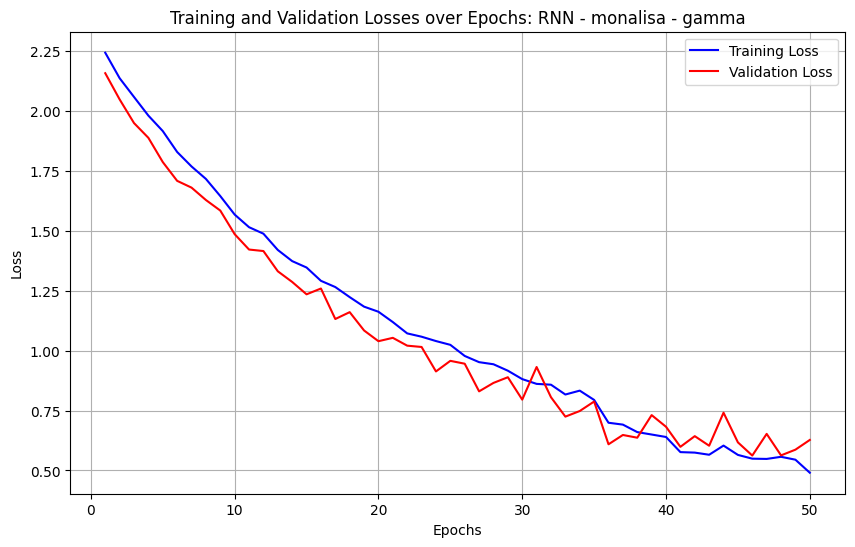

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([1+i for i in range(epochs)], train_losses, label='Training Loss', color='blue')
plt.plot([1+i for i in range(epochs)], val_losses, label='Validation Loss', color='red')
plt.title(f'Training and Validation Losses over Epochs: RNN - {dataset} - {band}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'{path}/{loss_fig_name}.png')
plt.show()

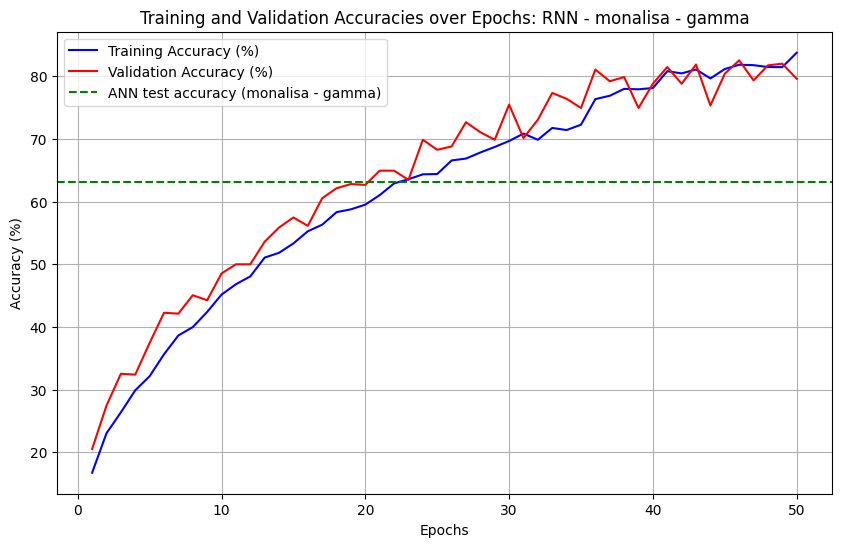

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([1+i for i in range(epochs)], train_accuracies, label='Training Accuracy (%)', color='blue')
plt.plot([1+i for i in range(epochs)], val_accuracies, label='Validation Accuracy (%)', color='red')
plt.axhline(y=100*prev_acc[band][dataset], color='green', linestyle='--', label=f'ANN test accuracy ({dataset} - {band})')
plt.title(f'Training and Validation Accuracies over Epochs: RNN - {dataset} - {band}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig(f'{path}/{acc_fig_name}.png')
plt.show()

In [ ]:
def model_test():
    # Testing
    RNN_model.eval()
    epoch_test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(test_loader, desc="Testing")
    for X_batch, y_batch in progress_bar:
        with torch.no_grad():
            output = RNN_model(X_batch)
            loss = loss_fct(output, y_batch)
            epoch_test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(output, 1)
            correct_predictions += (predicted == y_batch).sum().item()
            total_predictions += y_batch.size(0)

            # Collect predictions and labels for F1 score
            all_preds.extend(predicted.detach().cpu().numpy())
            all_labels.extend(y_batch.detach().cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix(test_loss=loss.item())

    # Average test loss
    test_loss = epoch_test_loss / len(test_loader)
    # Accuracy
    test_accuracy = 100 * correct_predictions / total_predictions
    # F1 score
    test_f1 = 100 * f1_score(all_labels, all_preds, average='macro')
    # Recall
    test_recall = 100 * recall_score(all_labels, all_preds, average='macro')
    # Precision
    test_precision = 100 * precision_score(all_labels, all_preds, average='macro')

    # Optional: Detailed classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    # Generate Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    return test_loss, test_accuracy, test_f1, test_recall, test_precision, cm

In [ ]:
test_loss, test_accuracy, test_f1, test_recall, test_precision, cm = model_test()

Testing: 100%|██████████| 24/24 [00:00<00:00, 105.11it/s, test_loss=0.779]



Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83        77
           1       0.81      0.73      0.77        90
           2       0.81      0.87      0.83        67
           3       0.89      0.74      0.81        77
           4       0.85      0.83      0.84        81
           5       0.75      0.92      0.83        65
           6       0.80      0.81      0.81        64
           7       0.83      0.75      0.79        80
           8       0.84      0.88      0.86        74
           9       0.76      0.83      0.79        75

    accuracy                           0.81       750
   macro avg       0.82      0.82      0.82       750
weighted avg       0.82      0.81      0.81       750



In [ ]:
with torch.no_grad():
    output = RNN_model(X_test_tensor)
    # Calculate accuracy
    _, predicted = torch.max(output, 1)
    true_preds = (predicted == y_test_tensor).sum().item()
    all_preds = y_test_tensor.size(0)
    print(f'Accuracy over all test tensor: {100*true_preds/all_preds:.2f}%')


Accuracy over all test tensor: 81.47%


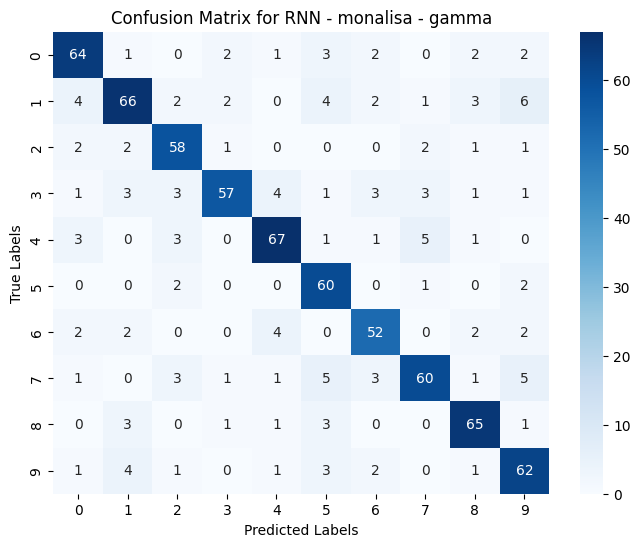

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix for RNN - {dataset} - {band}')
plt.savefig(f'{path}/{cm_fig_name}.png')
plt.show()

Make a log of the experiment:

In [ ]:
log = f'''
RNN-based model with Tanh activation
Dataset: {dataset}
Hardware: colab T4 GPU
Frequency channels: {band}
All EEG channels (left and right hemispheres)
Temporal sequence length: {sequence_length}
Batch size: {batch_size}
Optimiser: RMSProp, 1e-4 with a scheduler
epochs: {epochs}
Autocast: off
'''
log_res = ''
log_res += f'\nAverage test loss: {test_loss:.3f}'
log_res += f'\nTest accuracy: {test_accuracy:.3f}%'
log_res += f'\nTest F1 score: {test_f1:.3f}%'
log_res += f'\nTest Recall: {test_recall:.3f}%'
log_res += f'\nTest Precision: {test_precision:.3f}%'
log_res += f'\nTraining time (s): {duration:.1f}'
log += log_res
print(log)
with open(f'{path}/{log_file_name}.txt', 'w') as f:
    f.write(log)


RNN-based model with Tanh activation
Dataset: monalisa
Hardware: colab T4 GPU
Frequency channels: gamma
All EEG channels (left and right hemispheres)
Temporal sequence length: 100
Batch size: 32
Optimiser: RMSProp, 1e-4 with a scheduler
epochs: 50
Autocast: off

Average test loss: 0.643
Test accuracy: 81.467%
Test F1 score: 81.523%
Test Recall: 81.882%
Test Precision: 81.632%
Training time (s): 247.4


In [ ]:
rnn_results_dict[dataset][band] = log_res[1:].replace('\n', ', ')
with open(f'results/rnn/rnn_results_dict.json', 'w') as f:
    json.dump(rnn_results_dict, f, indent=4)

In [ ]:
rnn_results_dict

{'cube': {},
 'monalisa': {'gamma': 'Average test loss: 0.643, Test accuracy: 81.467%, Test F1 score: 81.523%, Test Recall: 81.882%, Test Precision: 81.632%, Training time (s): 247.4'}}

Neural Architecture Search (NAS) for the optimal RNN network configuration:

In [ ]:
import itertools

def nas_manual_loop():
    candidate_sizes = [128, 256, 512]
    best_config = None
    best_score = 0.0
    metric_weights = [0.3, 0.3, 0.2, 0.2]
    alpha = 1.0
    all_results = {}

    # Loop over all possible combinations of the three RNN layers.
    for h1, h2, h3 in itertools.product(candidate_sizes, repeat=3):
        config = {'h_size_1': h1, 'h_size_2': h2, 'h_size_3': h3}
        print(f"Trying configuration: {config}")

        # Create the rnn_layers tuple and instantiate your model.
        rnn_layers = (h1, h2, h3)
        global RNN_model  # Required if your training functions refer to the global model variable.
        RNN_model = EEG_RNN((batch_size, sequence_length, n_channels), n_classes, rnn_layers=rnn_layers).to(device)

        # Reinitialize optimizer and GradScaler for this trial.
        global optimizer
        optimizer = torch.optim.RMSprop(RNN_model.parameters(), lr=1e-4)
        global scaler
        scaler = GradScaler()

        # Train the model using your existing model_train() function.
        train_losses, train_accuracies, val_losses, val_accuracies, duration = model_train()

        # Evaluate the model using your existing model_test() function.
        test_loss, test_accuracy, test_f1, test_recall, test_precision = model_test()
        test_scores = test_accuracy, test_f1, test_recall, test_precision

        # Record the result for this configuration.
        #custom score: wighted average of metrics minus time penalty
        custom_score = (sum([w*metric/100 for w, metric in zip(metric_weights, test_scores)]) - alpha*duration/3600)*100
        stats = {'accuracy': test_accuracy,
                 'f1': test_f1,
                 'recall': test_recall,
                 'precision': test_precision,
                 'execution_time': duration,
                 'score': custom_score}
        all_results[str(config)] = stats
        print(f"Configuration {config} produced the score: {custom_score:.3f}%")

        # Update the best configuration if this one is better.
        if custom_score > best_score:
            best_score = custom_score
            best_config = config

    print("Best configuration found:")
    print(f"{best_config} with the score: {best_score:.3f}%")
    return best_config, best_score, all_results

In [ ]:
NAS_key = False
if NAS_key:
    best_config, best_accuracy, results = nas_manual_loop()

In [ ]:
#dummy_var

#### Shap Analysis

In [ ]:
torch.cuda.empty_cache()
RNN_model.eval()

# 1. Background Data Preparation: apply kmeans over all training samples
num_background = 50
custom_sequence_len = 30
n_kmeans_samples = 3000
#background_idx = np.random.choice(X_train.shape[0], num_background, replace=False)
background_samples = X_train[:n_kmeans_samples, :custom_sequence_len, :]
background_flat = background_samples.reshape(n_kmeans_samples, -1)  # shape = (nsamples, sequence_length*n_channels)
kmeans_bg = KMeans(n_clusters=num_background, random_state=42, n_init=10)
kmeans_bg.fit(background_flat)
# Get the cluster centers as bg
background_flat = kmeans_bg.cluster_centers_


# 2. Model Prediction Function
def model_predict(flat_inputs):
    # Reshape flattened inputs back to (samples, custom_sequence_len, n_channels)
    inputs_3d = flat_inputs.reshape(-1, custom_sequence_len, n_channels)
    x = torch.tensor(inputs_3d, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = RNN_model(x)
        # Convert logits to probabilities (if applicable)
        probs = torch.softmax(outputs, dim=1)
    return probs.cpu().numpy()

# 3. Initialize the SHAP KernelExplainer
explainer = shap.KernelExplainer(model_predict, background_flat)

# 4. Prepare Test Data
num_test_samples = 20
test_samples_np = X_test[:num_test_samples, :custom_sequence_len, :]
test_samples_flat = test_samples_np.reshape(num_test_samples, -1)  # shape: (20, custom_sequence_len*n_channels)

# 5. Compute SHAP Values
nsamples = 200
shap_values_all = explainer.shap_values(test_samples_flat, nsamples=nsamples)

# 6. Custom feature names for plotting
feature_names = []
for t in range(custom_sequence_len):
    for i, ch in enumerate(channels.tolist()):
        feature_names.append(f"{ch}_t{t}")

assert len(feature_names) == test_samples_flat.shape[1]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
test_samples_flat.shape

(20, 930)

In [ ]:
expected_feat_count = shap_values_all.shape[1]
actual_num_samples = shap_values_all.shape[0]
num_classes = shap_values_all.shape[2]
feature_count = test_samples_flat.shape[1]

print(f"\nKernelExplainer computed SHAP values for {actual_num_samples} samples.")

# Per-sample class influence analysis
for i in range(actual_num_samples):
    # Calculate class influence using absolute SHAP values
    class_influences = [np.sum(np.abs(shap_values_all[i, :, c])) for c in range(num_classes)]
    max_class = np.argmax(class_influences)

    # Get feature-level importance
    sample_shap = shap_values_all[i, :, max_class].flatten()
    max_feature_index = np.argmax(np.abs(sample_shap))

    # Convert flat index to temporal-channel format
    time_step = max_feature_index // n_channels
    channel_idx = max_feature_index % n_channels

    print(f"\nSample {i}:")
    print(f"  Most influential class: {max_class} (Total influence: {class_influences[max_class]:.3f})")
    print(f"  Most influential feature: Index {max_feature_index}")
    print(f"  Corresponding to: Time step {time_step}, Channel {channels[channel_idx]}")

# Aggregate feature importance (temporal-channel level)
all_shap = shap_values_all.reshape(-1, feature_count, num_classes) # Reshape to (n_samples * n_classes, n_features, 1)
feature_importance = np.mean(np.abs(all_shap), axis=(0, 2)).flatten()
sorted_indices = np.argsort(-feature_importance)

# Print top 10 important temporal-channel features
print("\nTop 10 important features (temporal-channel):")
for idx in sorted_indices[:10]:
    time_step = idx // n_channels
    channel = channels[idx % n_channels]
    print(f"Time {time_step:02d} | Channel {channel:15} | Importance: {feature_importance[idx]:.4f}")


KernelExplainer computed SHAP values for 20 samples.

Sample 0:
  Most influential class: 0 (Total influence: 0.938)
  Most influential feature: Index 352
  Corresponding to: Time step 11, Channel T5-A1

Sample 1:
  Most influential class: 5 (Total influence: 0.814)
  Most influential feature: Index 537
  Corresponding to: Time step 17, Channel T6-A2

Sample 2:
  Most influential class: 3 (Total influence: 0.453)
  Most influential feature: Index 888
  Corresponding to: Time step 28, Channel Fpz-A2

Sample 3:
  Most influential class: 3 (Total influence: 0.934)
  Most influential feature: Index 73
  Corresponding to: Time step 2, Channel T5-A1

Sample 4:
  Most influential class: 0 (Total influence: 0.606)
  Most influential feature: Index 776
  Corresponding to: Time step 25, Channel O1-A1

Sample 5:
  Most influential class: 3 (Total influence: 0.442)
  Most influential feature: Index 435
  Corresponding to: Time step 14, Channel O1-A1

Sample 6:
  Most influential class: 0 (Total i

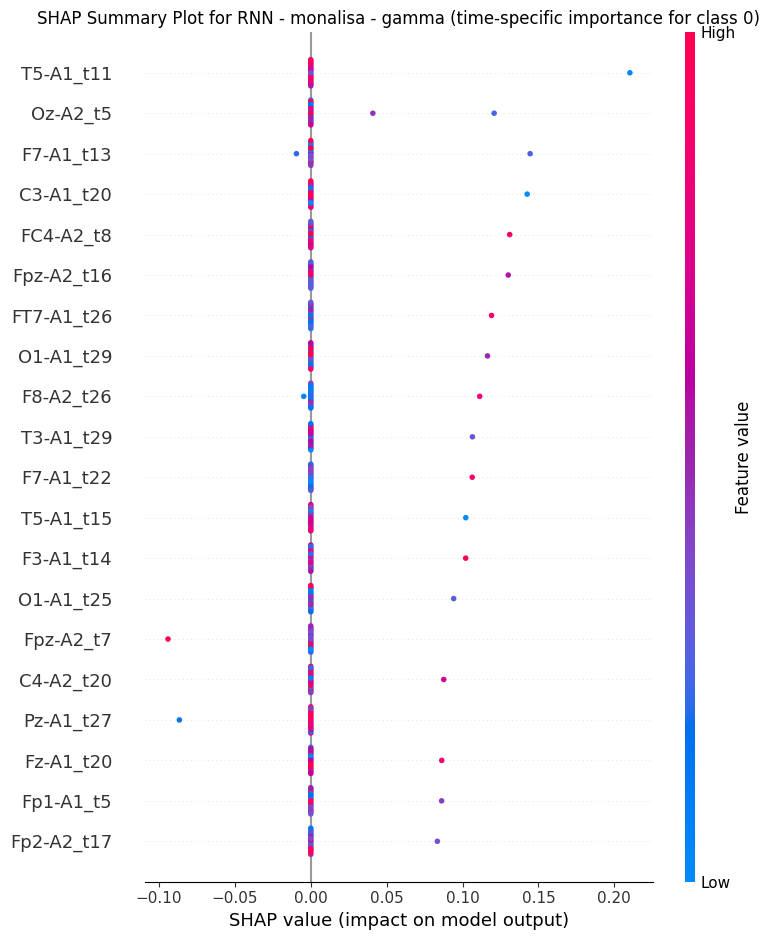

In [ ]:
os.makedirs(path+'/shap_summary_time-specific', exist_ok=True)
# 6. SHAP Summary Plots per Class
for i in range(n_classes):
    fig = plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_all[:,:,i], features=test_samples_flat, feature_names=feature_names, show=False)
    plt.title(f'SHAP Summary Plot for RNN - {dataset} - {band} (time-specific importance for class {i})')
    plt.tight_layout()
    plt.savefig(f'{path}/shap_summary_time-specific/{shap_fig_summary}_class{i}.png')
    if i==0:
        plt.show()
    else:
        plt.close(fig)

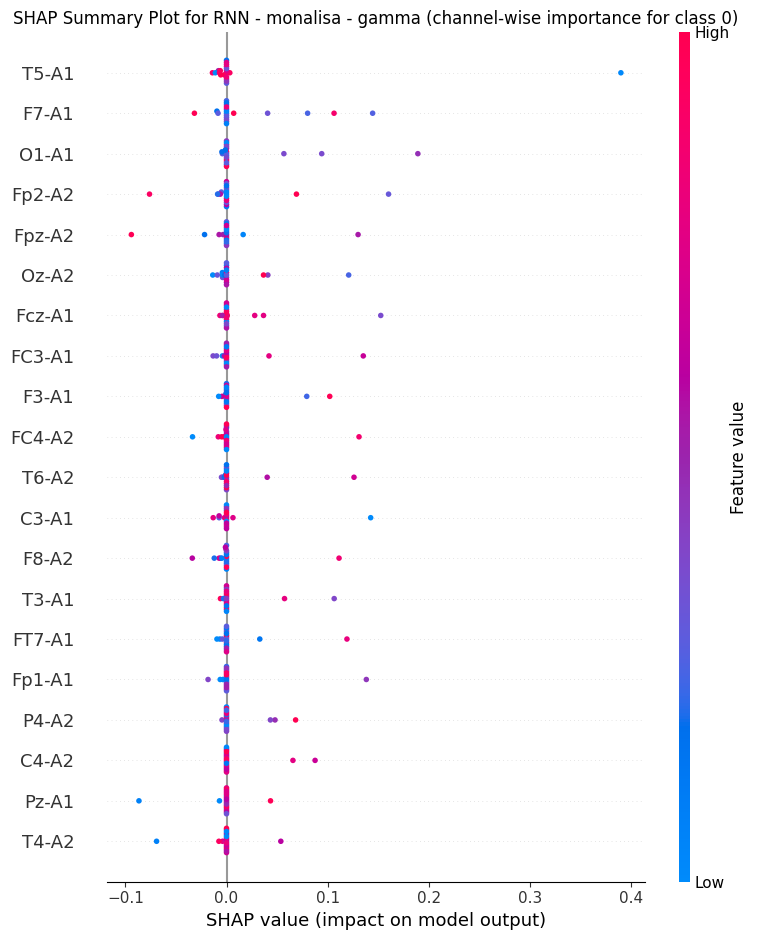

In [ ]:
os.makedirs(path+'/shap_summary_channel-wise', exist_ok=True)
# 6. SHAP Summary Plots per Class
for i in range(n_classes):
    # 1. Reshape the flattened SHAP values back to (samples, custom_sequence_len, n_channels)
    shap_values_reshaped = shap_values_all[:,:,i].reshape(test_samples_np.shape[0], custom_sequence_len, n_channels)

    # 2. Sum over the time (sequence) dimension to get channel-wise SHAP values.
    #    This gives an array of shape (samples, n_channels)
    shap_values_channel = np.sum(shap_values_reshaped, axis=1)

    # 3. Similarly, obtain the test features.
    #    The mean over time for each channel to obtain channel-level feature values.
    test_samples_channel = np.mean(test_samples_np, axis=1)

    # 4. Plot the channel-wise SHAP values.
    fig = plt.figure(figsize=(10,6))
    shap.summary_plot(shap_values_channel, features=test_samples_channel, feature_names=channels.tolist(), show=False)
    plt.title(f'SHAP Summary Plot for RNN - {dataset} - {band} (channel-wise importance for class {i})')
    plt.tight_layout()
    plt.savefig(f'{path}/shap_summary_channel-wise/{shap_fig_ch_importance}_class{i}.png')
    if i==0:
        plt.show()
    else:
        plt.close(fig)


Top 10 important channels (overall - RNN - monalisa - gamma):
Channel FC3-A1          | Importance: 0.0115
Channel Fp2-A2          | Importance: 0.0108
Channel O1-A1           | Importance: 0.0098
Channel F7-A1           | Importance: 0.0085
Channel O2-A2           | Importance: 0.0079
Channel Cz-A2           | Importance: 0.0078
Channel T5-A1           | Importance: 0.0077
Channel CP4-A2          | Importance: 0.0074
Channel FT7-A1          | Importance: 0.0073
Channel T3-A1           | Importance: 0.0071


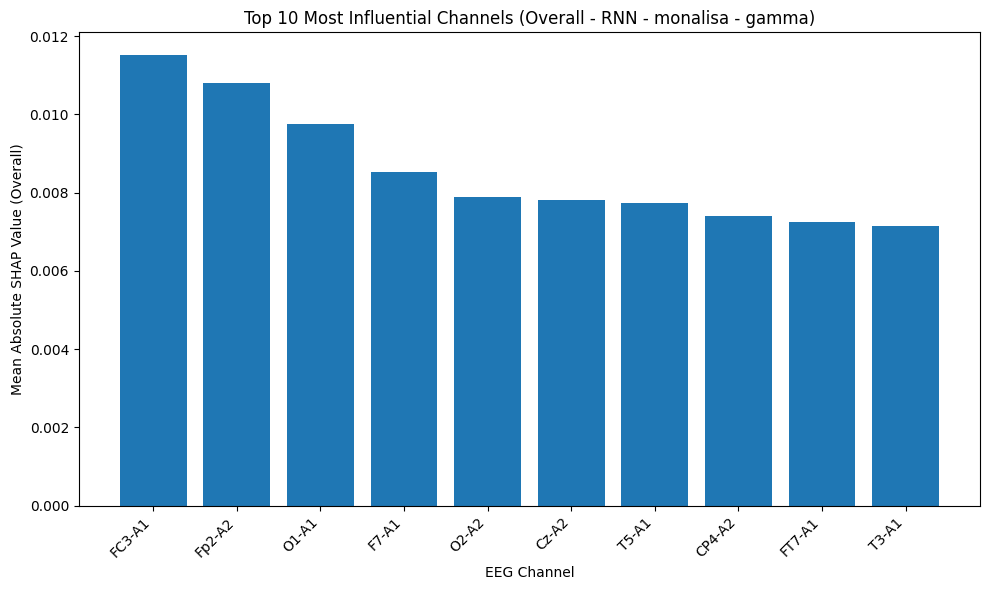

In [ ]:
mean_abs_shap_per_channel_rnn = np.zeros(len(channels))

# Take the absolute value of SHAP values
abs_shap_values = np.abs(shap_values_all)  # Shape: (num_test_samples, n_features, n_classes)

# Reshape to (num_test_samples, custom_sequence_len, n_channels, n_classes)
reshaped_shap = abs_shap_values.reshape(test_samples_np.shape[0], custom_sequence_len, n_channels, len(shap_values_all[0][0]))

# Average across samples
mean_abs_shap_over_samples = np.mean(reshaped_shap, axis=0) # Shape: (custom_sequence_len, n_channels, n_classes)

# Sum across the time dimension
sum_abs_shap_over_time = np.sum(mean_abs_shap_over_samples, axis=0) # Shape: (n_channels, n_classes)

# Average across the classes to get an overall channel importance
mean_abs_shap_per_channel_rnn = np.mean(sum_abs_shap_over_time, axis=1) # Shape: (n_channels,)

sorted_indices = np.argsort(-mean_abs_shap_per_channel_rnn)
top_n = 10

print(f"\nTop {top_n} important channels (overall - RNN - {dataset} - {band}):")
for i in range(top_n):
    channel_index = sorted_indices[i]
    channel_name = channels[channel_index]
    importance = mean_abs_shap_per_channel_rnn[channel_index]
    print(f"Channel {channel_name:15} | Importance: {importance:.4f}")

# 8. (Optional) Bar Plot of Overall Feature Importance (Channel-wise for RNN - CORRECTED)
plt.figure(figsize=(10, 6))
plt.bar(np.array(channels)[sorted_indices[:top_n]], mean_abs_shap_per_channel_rnn[sorted_indices[:top_n]])
plt.xlabel("EEG Channel")
plt.ylabel("Mean Absolute SHAP Value (Overall)")
plt.title(f"Top {top_n} Most Influential Channels (Overall - RNN - {dataset} - {band})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'{path}/rnn_shap_top{top_n}-feats_{dataset}_{band}')
plt.show()